In [81]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB, quicksum, max_
import time
import matplotlib.pyplot as plt
import random
import datetime

In [82]:
df = pd.read_csv('ft06csv.csv', sep=';')
df = df.sort_values(['Job','Job order'])

In [83]:
df

,Operation nr.,x,Job,Machine,Operation Time,Job order
0,1,1,1,3,1,1
1,7,2,1,1,3,2
2,13,3,1,2,6,3
3,19,4,1,4,7,4
4,25,5,1,6,3,5
5,31,6,1,5,6,6
6,2,7,2,2,8,1
7,8,8,2,3,5,2
8,14,9,2,5,10,3
9,20,10,2,6,10,4


In [84]:
ta01 = 'ta01' #37 3x3
ft06 = 'ft06' #55 6x6
ft10 = 'ft10' #930 10x10
ft20 = 'ft20' #1165 20x5
la01 = 'la01' #666 10x5
la03 = 'la03' #597 10x5
la05 = 'la05' #593 10x5
la06 = 'la06' #926 10x5
or06 = 'or06' #1010 10x10
sw01 = 'sw01' #1407 20x10
sw02 = 'sw02' #1475 20x10
dm32 = 'dm32' #5927 50x15
la31 = 'la31' #1784 30x10
la32 = 'la32' #1850 30x10
la33 = 'la33' #1719 30x10
la34 = 'la34' #1721 30x10
la35 = 'la35' #1888 30x10
G = 100000

In [85]:
def Orders(file):
    naam = file + 'csv.csv'
    df = pd.read_csv(naam, sep=';')
    df = df.sort_values(['Job','Job order'])
    jobs = max(df['Job'])
    machines = max(df['Machine'])
    df['Job']=df['Job']-1
    df['Machine'] = df['Machine'] - 1
    V = df['Machine'].to_numpy().reshape(jobs,machines)
    pr = df['Operation Time'].to_numpy().reshape(jobs,machines)
    df =df.sort_values(['Job','Machine'])
    pro = df['Operation Time'].to_numpy().reshape(jobs,machines)
    return jobs,machines,V,pro,pr

In [121]:
def ganttj(S): #Gantt Chart, gekeken vanuit de jobs
    cmap = plt.colormaps.get_cmap('tab20')
    plt.figure(figsize=(12, 6))
    for j in range(jobs):
        for m in range(machines):
            color = cmap(m / machines)
            plt.barh(j, pro[j,m], left = S[j,m], color=color,edgecolor='black',alpha = 0.6)

    plt.legend([f'Machine {m}' for m in range(machines)], bbox_to_anchor=(1.12, 0.5), loc='center right')
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.title('Gantt Chart')
    plt.yticks(range(jobs), [f'Job {j}' for j in range(jobs)])
    plt.grid(axis='x')
    plt.show()

def gantt(S): #Gantt Chart, gekeken vanuit de machines
    cmap = plt.colormaps.get_cmap('tab20')
    plt.figure(figsize=(12, 6))
    for m in range(machines):
        for j in range(jobs):
            color = cmap(j / jobs)
            plt.barh(m, pro[j,m], left = S[j,m], color=color,edgecolor='black',alpha = 0.6)

    plt.legend([f'Job {j+1}' for j in range(jobs)], bbox_to_anchor=(1.12, 0.5), loc='center right')
    plt.xlabel('Time')
    plt.ylabel('Machine')
    plt.title('Gantt Chart')
    plt.yticks(range(machines), [f'Machine {i+1}' for i in range(machines)])
    plt.grid(axis='x')
    plt.show()

In [122]:
jobs,machines,V,pro,pr = Orders(ft06)

In [88]:
mod = gp.Model()

mod.Params.NodefileStart=0.5
mod.Params.Threads=20
mod.Params.PreSparsify=1

# Doelvariabele
Ei = mod.addVar(lb=0, vtype=GRB.INTEGER, name='Ei')

# Starttijd variabele
S = np.empty((jobs, machines), dtype=gp.Var)
for j in range(jobs):
    for m in range(machines):
        S[j, m] = mod.addVar(lb=0, vtype=GRB.INTEGER, name=f'S{j},{m}')
        
X = np.empty((machines,jobs,jobs), dtype=gp.Var)
for m in range(machines):
    for j in range(jobs):
        for k in range(jobs):
            X[m, j,k] = mod.addVar(lb=0, vtype=GRB.BINARY, name=f'X{m},{j},{k}')


#Doelfunctie
mod.setObjective(Ei, GRB.MINIMIZE)


#mod.addConstrs(X[m,j,j] == 0 for m in range(machines) for j in range(jobs))
#Een machine heeft maar 1 voorganger en maar 1 opvolger
mod.addConstrs((quicksum(X[m, j, k] for j in range(jobs)) <= 1 for k in range(jobs) for m in range(machines)))
mod.addConstrs((quicksum(X[m, j, k] for k in range(jobs)) <= 1 for j in range(jobs) for m in range(machines)))

mod.addConstrs(quicksum(quicksum(X[m]))==jobs-1 for m in range(machines))

#Een machine kan niet twee jobs tegelijk
mod.addConstrs(S[k,m]>= S[j,m]+ pro[j,m]-G*(1-X[m,j,k]) for m in range(machines) for j in range(jobs) for k in range(jobs))

#Een job kan niet langs twee machines tegelijk
mod.addConstrs((S[j,V[j,m+1]]>= S[j,V[j,m]]+pro[j,V[j,m]]) for j in range(jobs) for m in range(machines-1))


#Doelvariabele constraint
mod.addConstrs(Ei >= S[j,m] + pro[j,m] for j in range(jobs) for m in range(machines))








#model optimaliseren
mod.optimize()

Set parameter NodefileStart to value 0.5
Set parameter Threads to value 20
Set parameter PreSparsify to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6234 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 32 logical processors, using up to 20 threads

Academic license 2377226 - for non-commercial use only - registered to jb___@hhs.nl
Optimize a model with 360 rows, 253 columns and 1356 nonzeros
Model fingerprint: 0x3cd01f14
Variable types: 0 continuous, 253 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 36 rows and 36 columns
Presolve time: 0.00s
Presolved: 324 rows, 217 columns, 1212 nonzeros
Variable types: 0 continuous, 217 integer (180 binary)

Root relaxation: objective 4.700000e+01, 105 iterations, 0.00 seconds (0.00 work units)

    Nodes  

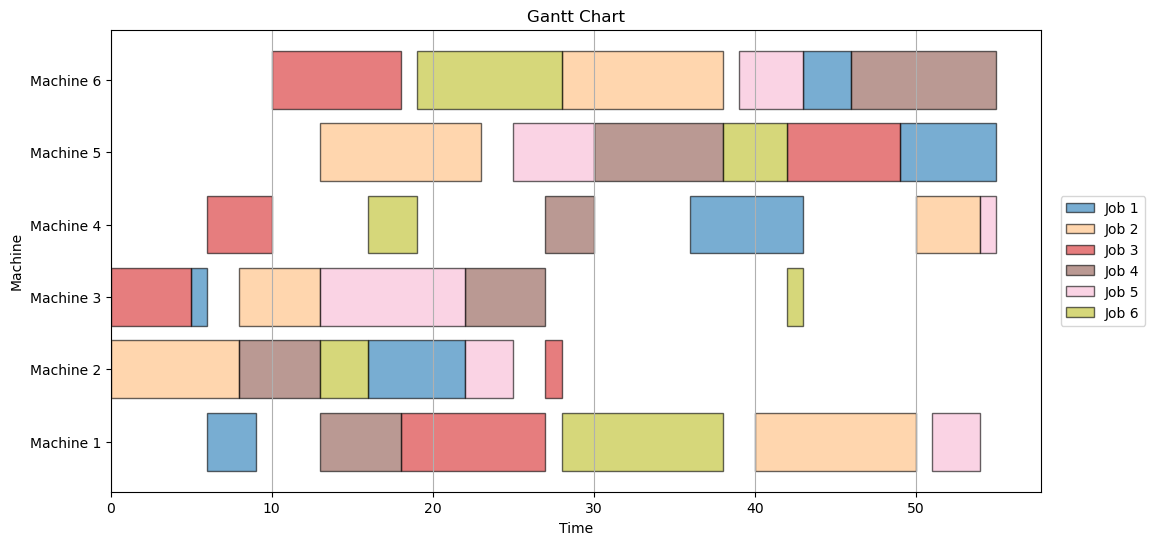

In [89]:
Sm = np.array([[var.x for var in row] for row in S])
gantt(Sm)

In [90]:
def Model(mvo,J,M,Vo,pt,ptv):
    mv = np.array(mvo)
    mod = gp.Model()
    mod.setParam('OutputFlag', 0)
    
    # Doelvariabele
    Ei = mod.addVar(lb=0, vtype=GRB.INTEGER, name='Ei')
    
    # Starttijd variabele
    S = np.empty((J, M), dtype=gp.Var)
    for j in range(J):
        for m in range(M):
            S[j, m] = mod.addVar(lb=0, vtype=GRB.INTEGER, name=f'S{j},{m}')
    #Doelfunctie
    mod.setObjective(Ei, GRB.MINIMIZE)

    #Doelvariabele constraint
    mod.addConstrs(Ei >= S[j,m] + pt[j,m] for j in range(J) for m in range(M))

    #Een job kan niet langs twee machines tegelijk
    mod.addConstrs(((S[j,Vo[j,m+1]]>= S[j,Vo[j,m]]+pt[j,Vo[j,m]]) for j in range(J) for m in range(M-1)),name = 'jj')
    
    #machine volgorde
    mod.addConstrs(((S[mv[m,j+1],m]>= S[mv[m,j],m]+pt[mv[m,j],m]) for m in range(M) for j in range(J-1)),name ='mm')

    #model optimaliseren
    mod.optimize()
    
    if mod.status == GRB.OPTIMAL:
        waarde= mod.objVal
    else:
        waarde = 'ongeldig'
    return waarde

def Ganttmodel(mvo):
    mv = np.array(mvo)
    mod = gp.Model()
    mod.setParam('OutputFlag', 0)
    
    # Doelvariabele
    Ei = mod.addVar(lb=0, vtype=GRB.INTEGER, name='Ei')
    
    # Starttijd variabele
    S = np.empty((jobs, machines), dtype=gp.Var)
    for j in range(jobs):
        for m in range(machines):
            S[j, m] = mod.addVar(lb=0, vtype=GRB.INTEGER, name=f'S{j},{m}')
    #Doelfunctie
    mod.setObjective(Ei, GRB.MINIMIZE)

    #Doelvariabele constraint
    mod.addConstrs(Ei >= S[j,m] + pro[j,m] for j in range(jobs) for m in range(machines))

    #Een job kan niet langs twee machines tegelijk
    mod.addConstrs(((S[j,V[j,m+1]]>= S[j,V[j,m]]+pro[j,V[j,m]]) for j in range(jobs) for m in range(machines-1)),name = 'jj')
    
    #machine volgorde
    mod.addConstrs(((S[mv[m,j+1],m]>= S[mv[m,j],m]+pro[mv[m,j],m]) for m in range(machines) for j in range(jobs-1)),name ='mm')

    #model optimaliseren
    mod.optimize()
    Sm = np.array([[var.x for var in row] for row in S])  
    return Sm

In [91]:
def Oplossing(manier,tijd,rev,J,M,Vo,pt,ptv):
    vlst = Vo.tolist()
    if tijd:        
        status = [[0,i,-1] for i in range(M)]
        mvn = [[] for _ in range(M)]
        
        while sum(len(lst) for lst in mvn) < J*M:
            status = sorted(status)
            for m in status:
                if m[2] > -1:
                    vlst[m[2]] = vlst[m[2]][1:]
                    m[2] = -1
                    t = m[0]
                    for ma in status:
                        if ma[0] != 0:
                            ma[0] -= t
                            
                mog = []
                for v in range(J):
                    if vlst[v]:
                        if vlst[v][0] == m[1]:
                            if manier == 'PT' or manier == 'shuffle':
                                mog.append([pt[v,m[1]],v]) #SPT
                            elif manier == 'RPT':
                                mog.append([sum(ptv[v,M-len(vlst):-1]),v]) #SRPT
                            elif manier== 'CoR':
                                mog.append([sum(ptv[v,M-len(vlst):-1])/sum(ptv[v,:]),v])  #procent
                mog = sorted(mog,reverse = rev)
                if manier == 'shuffle':
                    random.shuffle(mog)
                
                if mog:
                    m[0] = pt[mog[0][1],m[1]]
                    m[2] = mog[0][1]
                    mvn[m[1]].append(mog[0][1])
                    break
                    
    else:
        mv = [[[] for _ in range(J)] for _ in range(M)]
        for m in range(M):
            for j in range(J):
                mv[vlst[j][m]][m].append(j)
        
        for m in range(M):
            for j in range(J):
                if mv[m][j]:
                    lst = []                     
                    if manier == 'PT' or manier == 'shuffle':
                        for i in mv[m][j]:
                            lst.append((pt[i,m],i)) #SPT
                    elif manier == 'RPT':
                        for i in mv[m][j]:
                            lst.append((sum(ptv[i,j:-1]),i)) #SRPT
                    elif manier== 'CoR':
                        for i in mv[m][j]:
                            lst.append((sum(ptv[i,j:-1])/sum(ptv[i,:]),i)) #Completion Rate
                    
                    lst = sorted(lst,reverse = rev)  
                    if manier == 'shuffle':
                        random.shuffle(lst)
                    lst = [t[1] for t in lst]
                    mv[m][j] = lst
                    
        mvn = [[] for _ in range(M)]
        for m in range(M):
            for j in range(J):
                for i in mv[m][j]:
                    mvn[m].append(i)
    return mvn

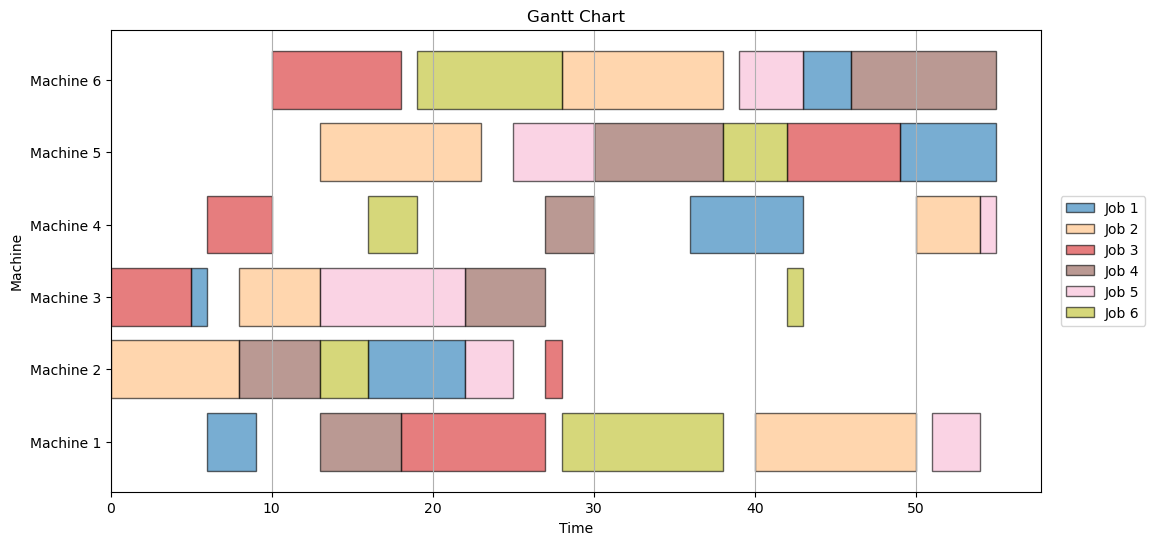

In [126]:
gantt(Sm)

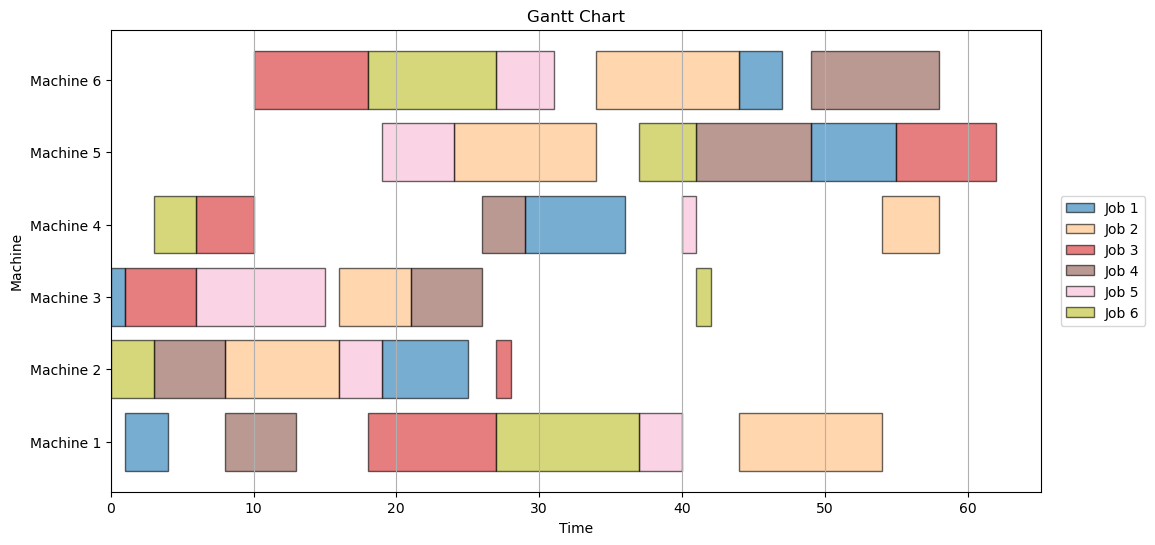

In [127]:
gantt(Ganttmodel(opl1))

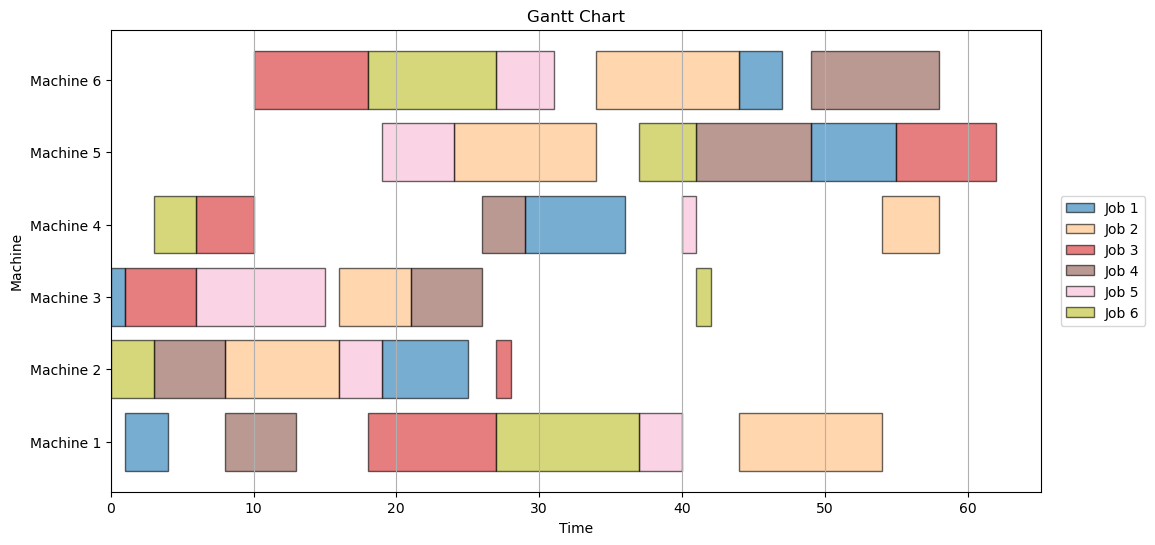

In [123]:
opl1 = Oplossing('PT',0,0,jobs,machines,V,pro,pr)
gantt(Ganttmodel(opl1))

In [93]:
opl1

[[0, 3, 2, 5, 4, 1],
 [5, 3, 1, 4, 0, 2],
 [0, 2, 4, 1, 3, 5],
 [5, 2, 3, 0, 4, 1],
 [4, 1, 5, 3, 0, 2],
 [2, 5, 4, 1, 0, 3]]

In [94]:
V

array([[2, 0, 1, 3, 5, 4],
       [1, 2, 4, 5, 0, 3],
       [2, 3, 5, 0, 1, 4],
       [1, 0, 2, 3, 4, 5],
       [2, 1, 4, 5, 0, 3],
       [1, 3, 5, 0, 4, 2]])

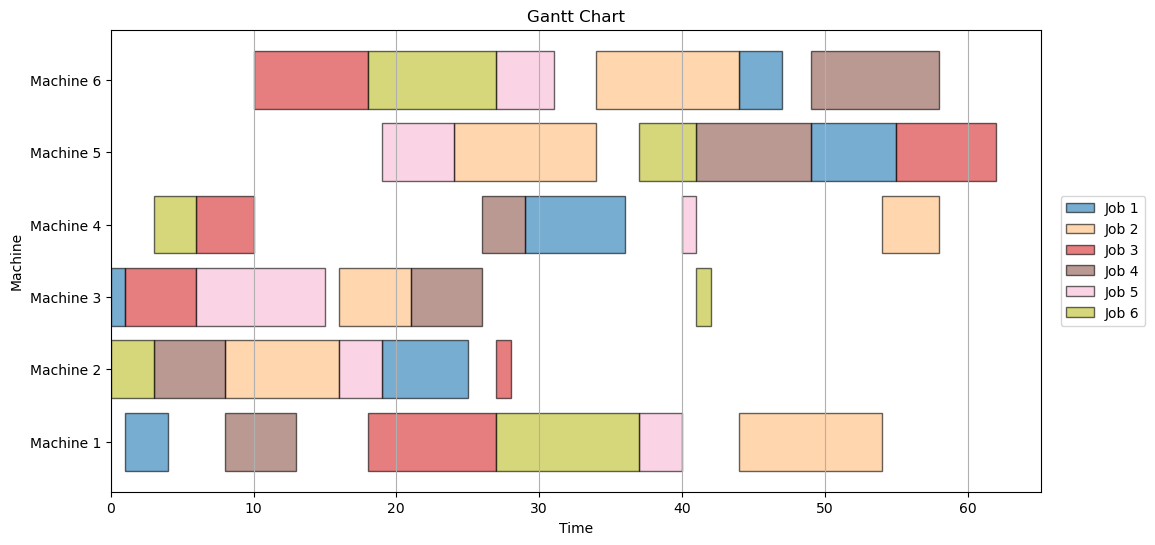

In [109]:
gantt(Ganttmodel(opl1))

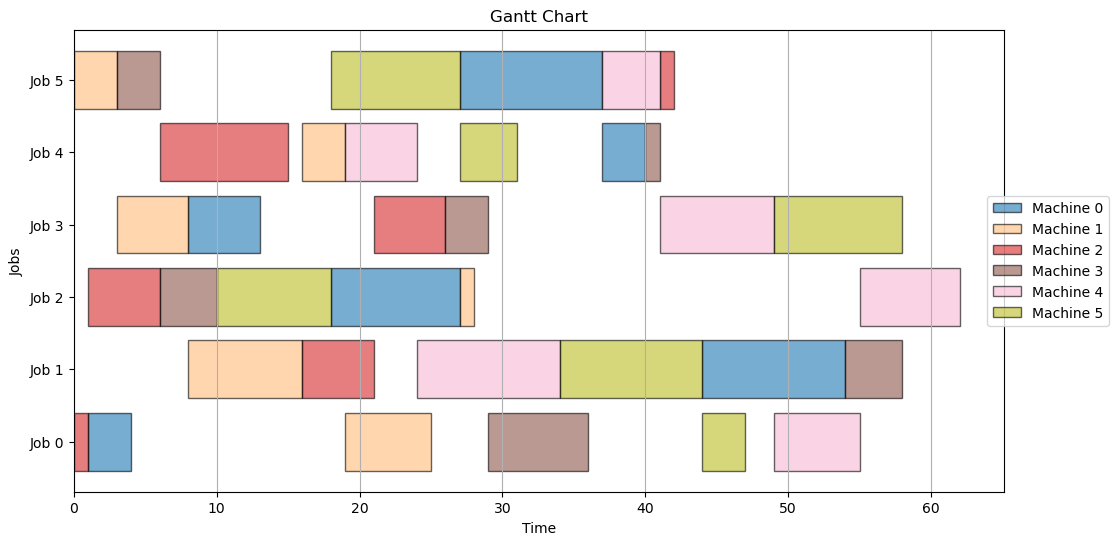

In [95]:
ganttj(Ganttmodel(opl1))

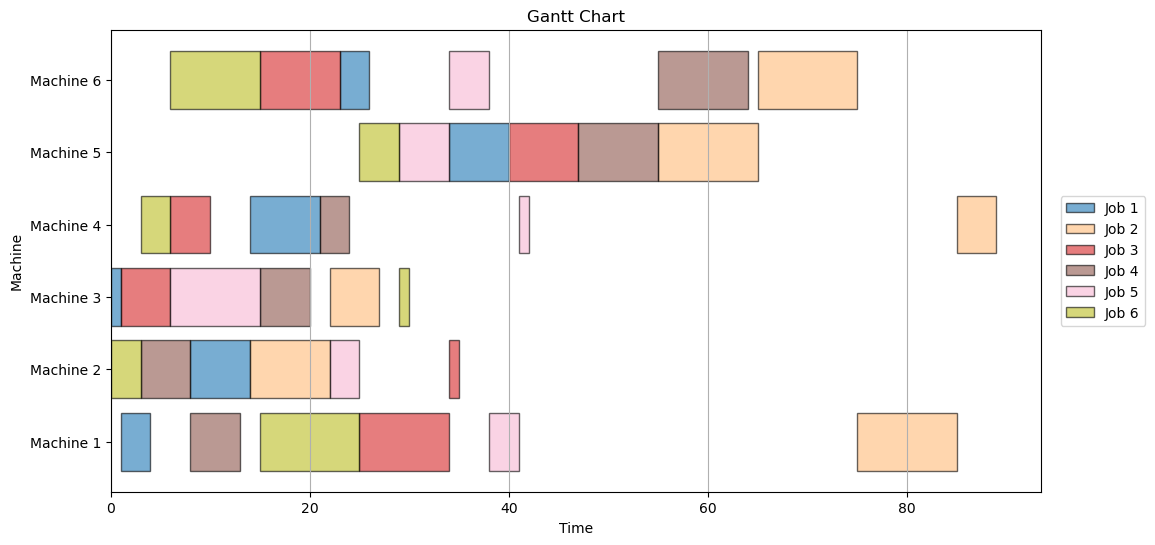

In [124]:
opl2 = Oplossing('PT',1,0,jobs,machines,V,pro,pr)
gantt(Ganttmodel(opl2))

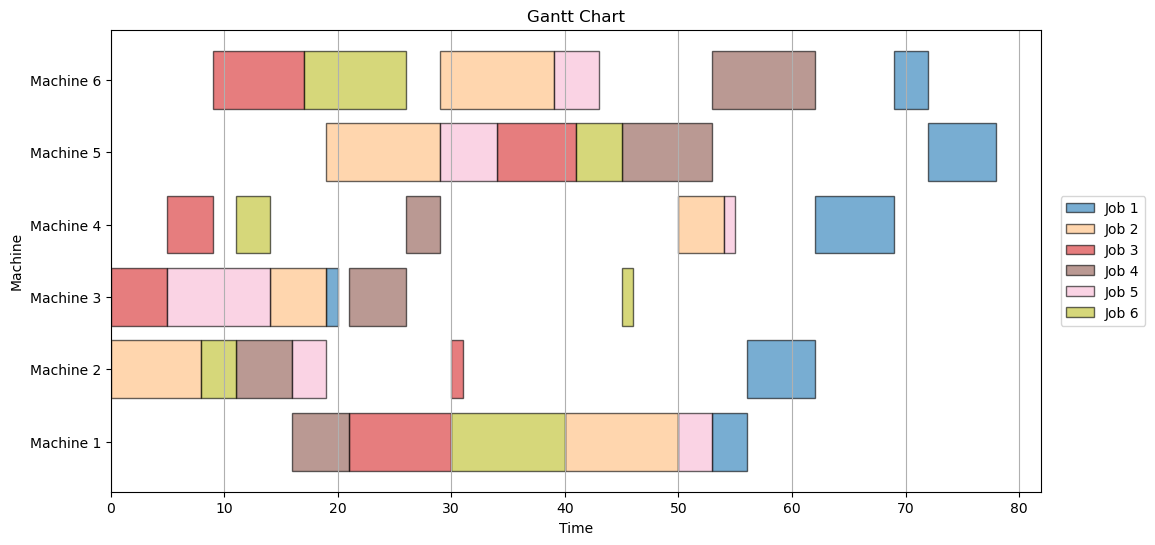

In [125]:
opl3 = Oplossing('RPT',1,1,jobs,machines,V,pro,pr)
gantt(Ganttmodel(opl3))

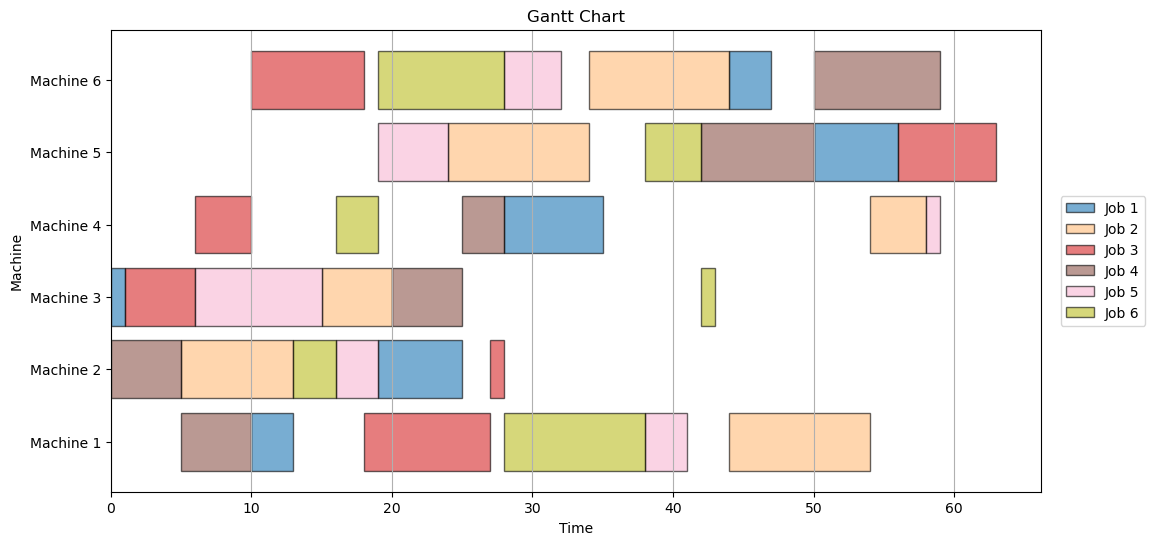

In [98]:
opl4 = Oplossing('CoR',0,0,jobs,machines,V,pro,pr)
gantt(Ganttmodel(opl4))

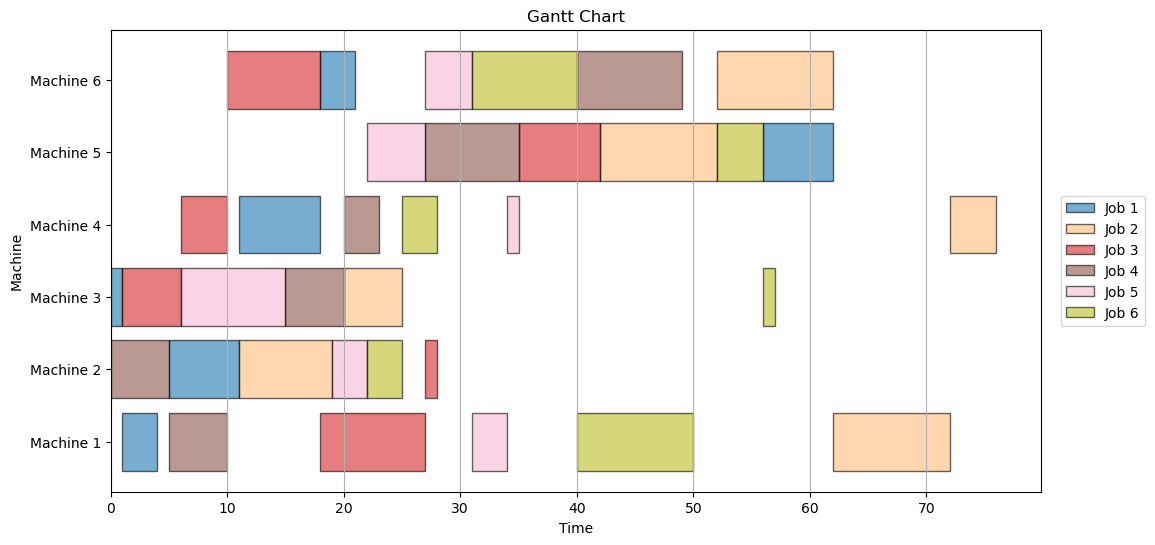

In [111]:
opl5 = Oplossing('shuffle',1,1,jobs,machines,V,pro,pr)   #nog eentje doen
gantt(Ganttmodel(opl5))

In [100]:
def create_pop(P,J,M,Vo,pt,ptv):
    population = []
    for manier in manieren:
        for t in tijd:
            for reverse in reverses:
                population.append(Oplossing(manier,t, reverse,J,M,Vo,pt,ptv))
    if len(population)>P:
        def evaluate_individual(individual):
            return evaluate(individual, J, M, Vo, pt, ptv)
        
        fitnesses = list(map(evaluate_individual, population))
        fitnesses = sorted(fitnesses)
        
        population = [i[1] for i in fitnesses][:P]
    else:
        while len(population)<P:
            rmv = []
            for i in range(M):
                lst = [p for p in range(J)]
                random.shuffle(lst)
                rmv.append(lst)
            rmv = reparatie(rmv,J,M,Vo,pt,ptv)
            if not modelll(rmv,J,M,Vo,pt,ptv) == 'ongeldig':
                population.append(rmv)
    return population

def evaluate(individual,J,M,Vo,pt,ptv):
    val = Model(individual,J,M,Vo,pt,ptv)
    if val =='ongeldig':
        individual = reparatie(individual,J,M,Vo,pt,ptv)
        val = Model(individual,J,M,Vo,pt,ptv)
        if val =='ongeldig':
            val = 10000
    return val,individual 

def rcrossover(ouder1,ouder2,J,M,Vo,pt,ptv):
    child = []
    l = len(ouder1[0])
    for m in range(M):
        gene = [-1 for _ in range(l)]
        r = random.randint(0,l)
        int1 = random.sample(range(l),r)
        copy_ouder = ouder2[m].copy()
        for v in int1:
            gene[v] = ouder1[m][v]
            if ouder1[m][v] in copy_ouder:
                copy_ouder.remove(ouder1[m][v])
        c = 0
        for i in range(l):
            if gene[i] == -1:
                gene[i] = copy_ouder[c]
                c+=1
        
        child.append(gene)
    return child

def grootcrossover(ouder1,ouder2,J,M,Vo,pt,ptv):
    child = []
    l = len(ouder1[0])
    grote = random.randint(l//2 - l//4,l//2+l//4)  
    positie = random.randint(0, l - grote)
    for m in range(M):
        gene = [-1 for _ in range(l)]
        copy_ouder = ouder2[m].copy()
        for v in range(grote):
            gene[positie+v] = ouder1[m][positie+v]
            copy_ouder.remove(ouder1[m][positie+v])
        c = 0
        for i in range(l):
            if gene[i] == -1:
                gene[i] = copy_ouder[c]
                c+=1
        child.append(gene)
    return child

def random_mutate(child):
    ll = len(child)-1
    kans = 1
    while kans > 0.4:
        rgene = random.randint(0,ll)
        mutations = [swap_mutate, inv_mutate, rotation_mutate]
        weights = [0.60, 0.30, 0.10]
        mutation = random.choices(mutations, weights=weights, k=1)[0]
        child[rgene] = mutation(child[rgene])
        kans = random.random()
    return child

def swap_mutate(gene):
    l = len(gene)-1
    inta = random.randint(0, l)
    intb = random.randint(0, l)
    gene[inta],gene[intb] = gene[intb],gene[inta]
    return gene
    
def inv_mutate(gene):
    l = len(gene)    
    length = random.randint(2, max(l // 4,2))
    pos = random.randint(0, l - length)
    inverted = gene[pos:pos+length][::-1]
    gene[pos:pos+length] = inverted
    return gene

def rotation_mutate(gene):
    direction = random.choice([-1, 1])
    pivot = random.randint(0, len(gene) - 1)
    rotated = gene[pivot:] + gene[:pivot]
    return rotated if direction == 1 else rotated[::-1]    
    
    
def reparatie(child,J,M,Vo,pt,ptv):
    rchild = child.copy()
    mv = child.copy()
    vlst = Vo.tolist()
    status = [[0,i,-1] for i in range(M)]
    t = 0
    while sum(len(lst) for lst in vlst) >0 and t<4000:
        fout = 0
        status = sorted(status)
        for m in status:
            if m[2] >-1:
                vlst[m[2]] = vlst[m[2]][1:]
                mv[m[1]] = mv[m[1]][1:]
                m[2] = -1
                t = m[0]
                fout = 1
                for ma in status:
                    if ma[0] != 0:
                        ma[0] -= t
            if mv[m[1]]:
                hj = mv[m[1]][0]
                if vlst[hj]:
                    if vlst[hj][0] == m[1]:
                        m[2] = hj
                        m[0] = pt[hj,m[1]]                
                        fout = 1
                        break
        if not fout:
            r = random.randint(0,M-1)
            if len(mv[r])>1:
                plek =J -len(mv[r])
                mog = []
                for v in range(J):
                    if vlst[v]:
                        if r == vlst[v][0]:
                            mog.append((pt[v,r],v))
                mog = sorted(mog)
                if mog:
                    wis = mv[r].index(mog[0][1]) 
                    wis2 = rchild[r].index(mog[0][1])
                    mv[r] = [mv[r][wis]] + mv[r][:wis] + mv[r][wis+1:]
                    rchild[r] = rchild[r][:plek] + [rchild[r][wis2]] + rchild[r][plek:wis2] + rchild[r][wis2+1:]
                
        t+= 1
    return rchild

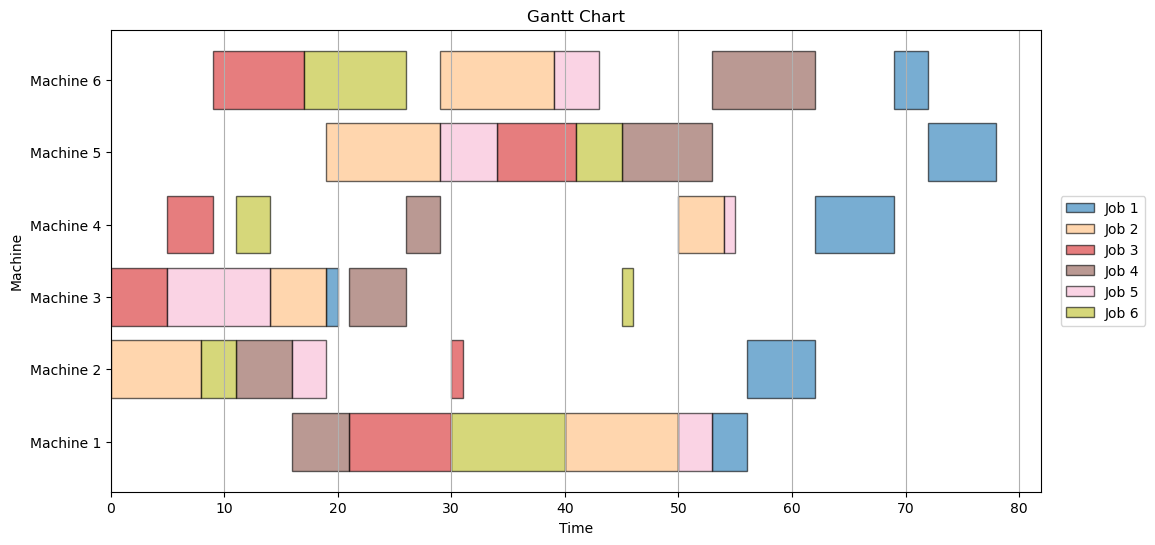

In [133]:
gantt(Ganttmodel(opl3))

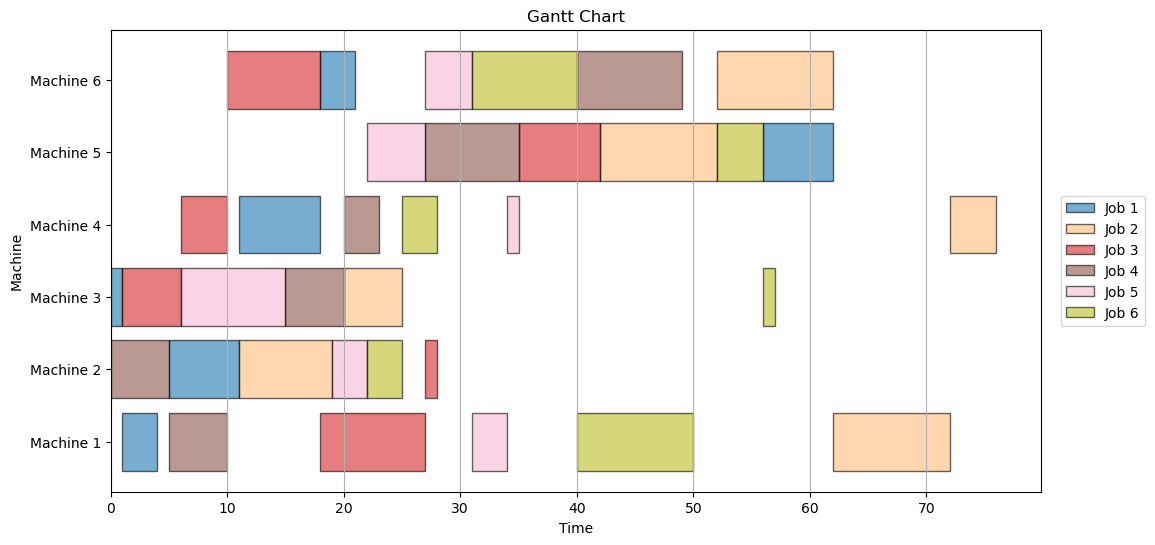

In [134]:
gantt(Ganttmodel(opl5))

In [224]:
Model(opl4,jobs,machines,V,pro,pr),Model(opl5,jobs,machines,V,pro,pr)

(63.0, 76.0)

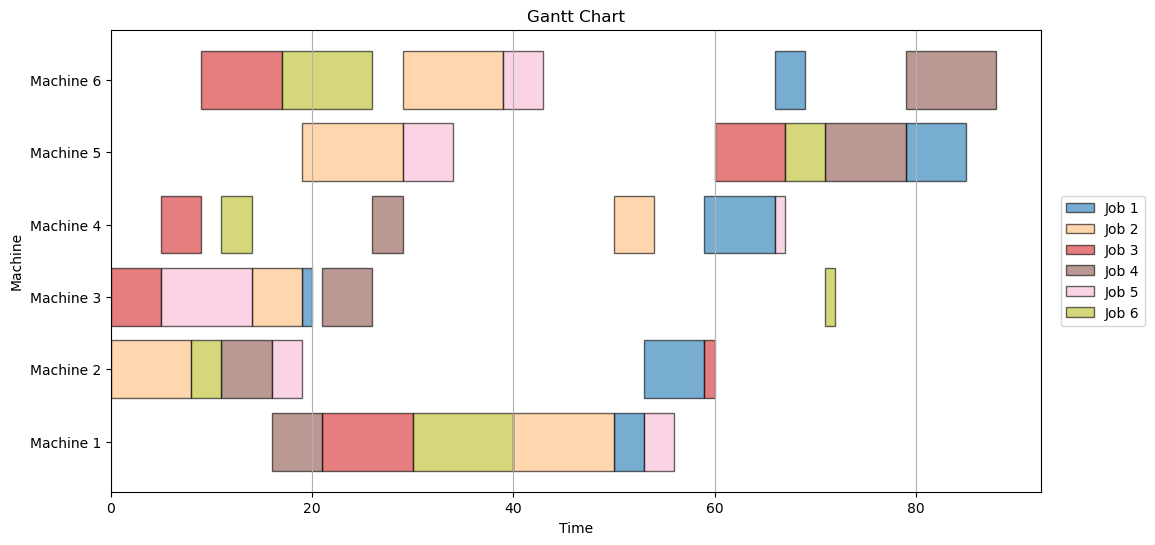

In [275]:
kind = grootcrossover(opl3,opl5,jobs,machines,V,pro,pr)
gantt(Ganttmodel(kind))

In [278]:
pop = create_pop(16,jobs,machines,V,pro,pr)

yes


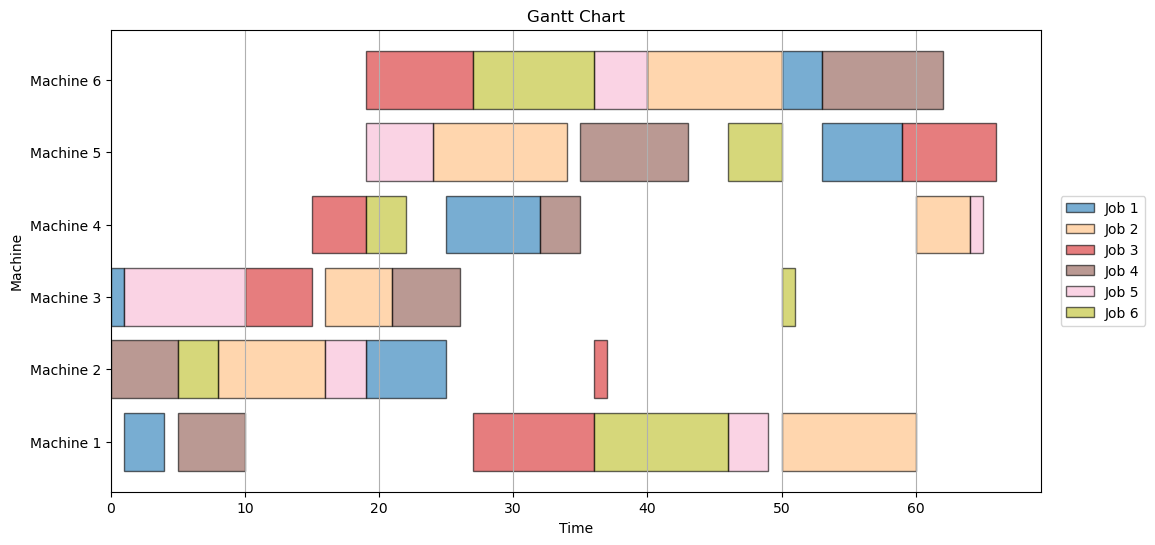

In [430]:
for i in range(100):
    q = pop[random.randint(0,15)]
    qq = pop[random.randint(0,15)]
    mi = min(Model(q,jobs,machines,V,pro,pr), Model(qq,jobs,machines,V,pro,pr))
    ki = grootcrossover(q,qq,jobs,machines,V,pro,pr)
    kii = reparatie(ki,jobs,machines,V,pro,pr)
    if Model(kii,jobs,machines,V,pro,pr)<mi:
        print('yes')
        break
gantt(Ganttmodel(kii))

In [431]:
Model(q,jobs,machines,V,pro,pr), Model(qq,jobs,machines,V,pro,pr)

(68.0, 71.0)

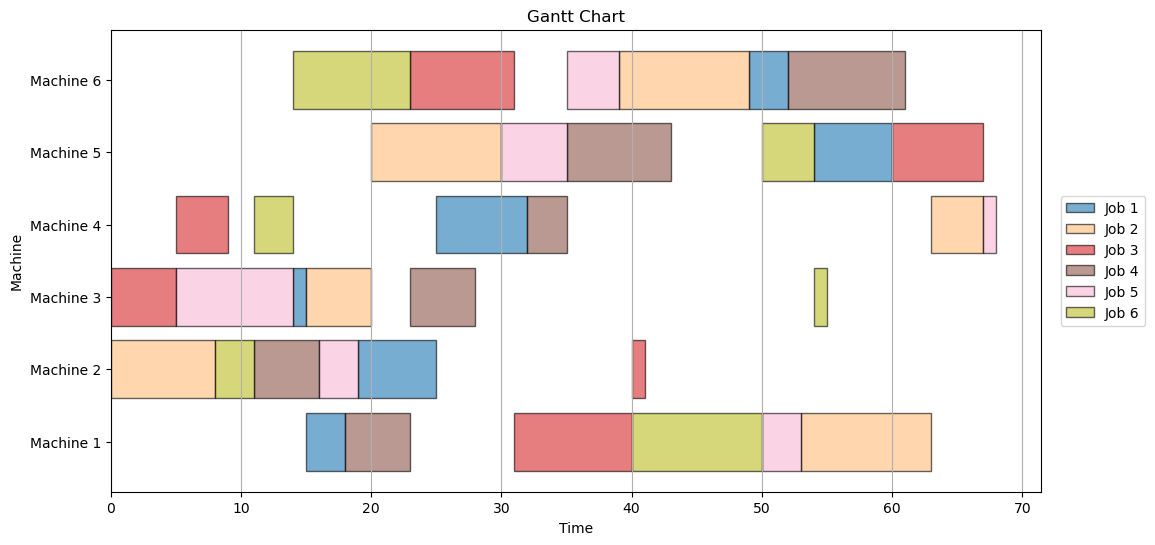

In [433]:
gantt(Ganttmodel(q))

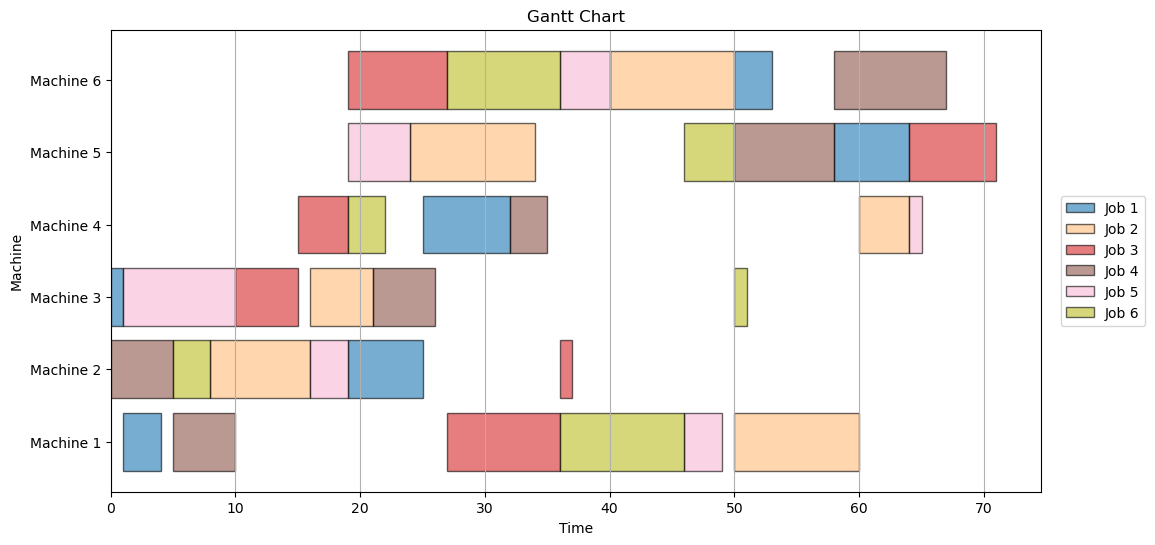

In [434]:
gantt(Ganttmodel(qq))

In [432]:
i

52

In [280]:
mi = min(Model(q,jobs,machines,V,pro,pr), Model(qq,jobs,machines,V,pro,pr))

(89.0, 75.0)

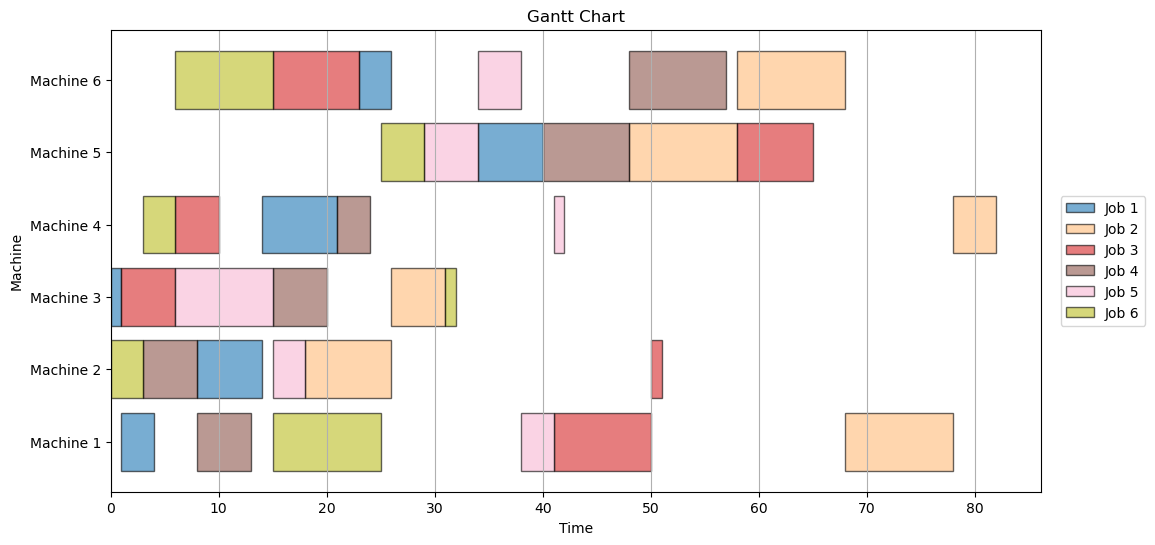

In [429]:
ki = grootcrossover(q,qq,jobs,machines,V,pro,pr)
kii = reparatie(ki,jobs,machines,V,pro,pr)
gantt(Ganttmodel(kii))

In [270]:
def GA(pop,ite,J,M,Vo,pt,ptv,Cp,Mu,El):
    l = len(pop)
    elitisme = round(l*El)
    def evaluate_individual(individual):
        return evaluate(individual, J, M, Vo, pt, ptv)
    
    tijdlijn = []
    fitnesses = list(map(evaluate_individual, pop))
    print('initial',[i[0] for i in fitnesses])
    g = 0
    while g < ite:
        g += 1
        ouders = sorted(fitnesses)
        tijdlijn.append(ouders[0][0])
        nouders = []
        for p in range(0,l-elitisme):
            tourn = random.sample(ouders,3)
            tourn = sorted(tourn)
            nouders.append(tourn[0])
        random.shuffle(nouders)
        seen = []
        nchilds = []
        for item in ouders:
            if item[0] not in seen:
                nchilds.append(item)
                seen.append(item[0])
        childs = nchilds[:elitisme]
        for ouderA, ouderB in zip(nouders[::2], nouders[1::2]):
            if Cp == 0:
                child1 = rcrossover(ouderA[1],ouderB[1],J,M,Vo,pt,ptv)
                child2 = rcrossover(ouderB[1],ouderA[1],J,M,Vo,pt,ptv)
            elif Cp == 1:
                child1 = grootcrossover(ouderA[1],ouderB[1],J,M,Vo,pt,ptv)
                child2 = grootcrossover(ouderB[1],ouderA[1],J,M,Vo,pt,ptv)
            if random.random()<Mu:
                child1 = random_mutate(child1)
            if random.random()<Mu:
                child2 = random_mutate(child2)
            childs.append((evaluate(child1, J, M, Vo, pt, ptv)))
            childs.append((evaluate(child2, J, M, Vo, pt, ptv)))
        
        fitnesses = childs.copy()
        if g%100 == 0:
            print(g,[i[0] for i in fitnesses])   
    return fitnesses,tijdlijn

In [53]:
manieren = ['PT','RPT','CoR','shuffle']
reverses = [0,1]
tijd = [0,1]
g = 1000
P = 16 
Cp =1 
Mu = 0.5
El = 0.2
def resultaat(file,g,P,Cp,Mu,El):
    jobs,machines,V,pro,pr = Orders(file)
    population = create_pop(P,jobs,machines,V,pro,pr)
    solution,tijdlijn = GA(population,g,jobs,machines,V,pro,pr,Cp,Mu,El)
    return solution,tijdlijn

In [63]:
sol1, tijd1 = resultaat(sw01,g,P,Cp,Mu,El)

initial [2867.0, 2644.0, 1727.0, 2250.0, 2478.0, 2534.0, 1925.0, 1842.0, 2489.0, 2399.0, 1867.0, 1898.0, 2762.0, 2758.0, 1952.0, 1979.0]
100 [1674.0, 1675.0, 1682.0, 3561.0, 3264.0, 1674.0, 2095.0, 2441.0, 1674.0, 1829.0, 1674.0, 2565.0, 1674.0, 1674.0, 1678.0]
200 [1660.0, 1664.0, 1665.0, 1664.0, 1664.0, 3829.0, 2178.0, 1699.0, 2189.0, 2220.0, 1664.0, 2797.0, 1660.0, 2321.0, 2247.0]
300 [1660.0, 1662.0, 1663.0, 1665.0, 1660.0, 1868.0, 2473.0, 1662.0, 2150.0, 1665.0, 1660.0, 2473.0, 1868.0, 1699.0, 1660.0]
400 [1660.0, 1662.0, 1663.0, 1805.0, 1660.0, 1660.0, 2568.0, 1974.0, 3095.0, 1660.0, 1660.0, 1660.0, 3522.0, 1767.0, 1660.0]
500 [1655.0, 1656.0, 1657.0, 2040.0, 1958.0, 1655.0, 1897.0, 1655.0, 2677.0, 1972.0, 1657.0, 2619.0, 1655.0, 1655.0, 1655.0]
600 [1655.0, 1656.0, 1657.0, 1865.0, 1655.0, 1655.0, 1655.0, 1655.0, 1655.0, 3346.0, 2916.0, 3389.0, 1655.0, 1655.0, 1655.0]
700 [1651.0, 1654.0, 1655.0, 1651.0, 4185.0, 2551.0, 1655.0, 2920.0, 1912.0, 1715.0, 3721.0, 2700.0, 3114.0, 1651

Text(0.5, 1.0, 'Verloop GA')

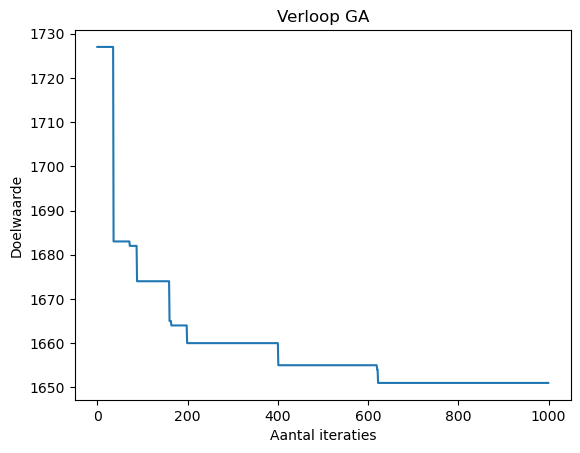

In [64]:
plt.plot(tijd1)
plt.xlabel('Aantal iteraties')
plt.ylabel('Doelwaarde')
plt.title('Verloop GA')

Text(0.5, 1.0, 'Verloop GA in %')

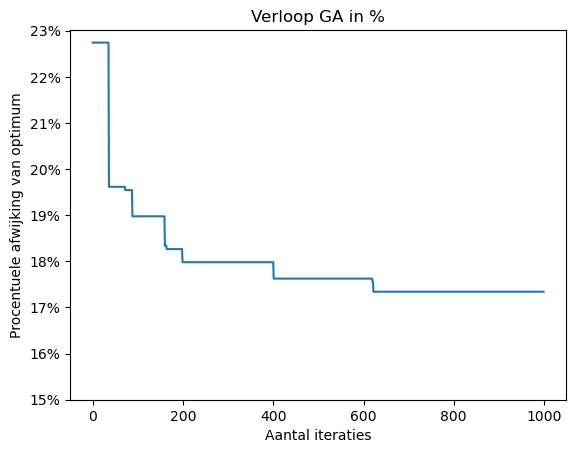

In [70]:
plt.plot([100*(i-1407)/1407 for i in tijd1])
plt.yticks(range(15,24,1), [f'{j}%' for j in range(15,24,1)])
plt.xlabel('Aantal iteraties')
plt.ylabel('Procentuele afwijking van optimum')
plt.title('Verloop GA in %')

In [79]:
sol2, tijd2 = resultaat(ft06,g,P,1,Mu,El)

initial [62.0, 64.0, 89.0, 67.0, 71.0, 61.0, 75.0, 78.0, 63.0, 60.0, 82.0, 88.0, 70.0, 65.0, 59.0, 67.0]
100 [59.0, 60.0, 61.0, 95.0, 105.0, 74.0, 61.0, 59.0, 124.0, 81.0, 59.0, 59.0, 81.0, 86.0, 80.0]
200 [59.0, 60.0, 61.0, 87.0, 59.0, 59.0, 103.0, 60.0, 59.0, 59.0, 65.0, 78.0, 71.0, 108.0, 59.0]
300 [59.0, 60.0, 61.0, 65.0, 59.0, 75.0, 66.0, 89.0, 59.0, 80.0, 98.0, 81.0, 59.0, 59.0, 59.0]
400 [59.0, 60.0, 61.0, 95.0, 81.0, 59.0, 140.0, 59.0, 75.0, 113.0, 69.0, 59.0, 59.0, 91.0, 68.0]
500 [59.0, 60.0, 61.0, 59.0, 65.0, 92.0, 59.0, 62.0, 105.0, 59.0, 68.0, 129.0, 85.0, 60.0, 59.0]
600 [59.0, 60.0, 61.0, 65.0, 59.0, 107.0, 70.0, 59.0, 60.0, 84.0, 79.0, 60.0, 60.0, 65.0, 63.0]
700 [59.0, 60.0, 61.0, 86.0, 138.0, 59.0, 59.0, 118.0, 65.0, 131.0, 59.0, 87.0, 59.0, 59.0, 59.0]
800 [59.0, 60.0, 61.0, 74.0, 90.0, 145.0, 59.0, 59.0, 77.0, 59.0, 93.0, 131.0, 69.0, 123.0, 60.0]
900 [59.0, 60.0, 61.0, 59.0, 59.0, 65.0, 59.0, 59.0, 59.0, 66.0, 59.0, 59.0, 59.0, 59.0, 59.0]
1000 [59.0, 60.0, 61.0, 6

In [80]:
sol3, tijd3 = resultaat(ft06,g,P,0,Mu,0.1)

initial [62.0, 64.0, 89.0, 67.0, 71.0, 61.0, 75.0, 78.0, 63.0, 60.0, 82.0, 88.0, 67.0, 67.0, 69.0, 68.0]
100 [58.0, 59.0, 58.0, 58.0, 68.0, 58.0, 58.0, 58.0, 58.0, 58.0, 58.0, 70.0, 72.0, 77.0, 92.0, 86.0]
200 [58.0, 59.0, 58.0, 58.0, 58.0, 87.0, 70.0, 58.0, 87.0, 81.0, 144.0, 58.0, 110.0, 89.0, 90.0, 71.0]
300 [57.0, 58.0, 57.0, 57.0, 103.0, 65.0, 57.0, 90.0, 104.0, 57.0, 57.0, 71.0, 57.0, 65.0, 57.0, 57.0]
400 [57.0, 58.0, 120.0, 57.0, 57.0, 57.0, 86.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 61.0, 57.0, 57.0]
500 [57.0, 58.0, 60.0, 92.0, 107.0, 57.0, 68.0, 57.0, 57.0, 57.0, 57.0, 57.0, 91.0, 101.0, 61.0, 57.0]
600 [57.0, 58.0, 57.0, 57.0, 68.0, 57.0, 123.0, 57.0, 57.0, 57.0, 95.0, 96.0, 58.0, 58.0, 57.0, 57.0]
700 [57.0, 58.0, 98.0, 71.0, 71.0, 78.0, 57.0, 61.0, 75.0, 121.0, 57.0, 57.0, 73.0, 63.0, 57.0, 57.0]
800 [57.0, 58.0, 71.0, 68.0, 104.0, 57.0, 58.0, 57.0, 57.0, 60.0, 123.0, 76.0, 57.0, 57.0, 77.0, 81.0]
900 [57.0, 58.0, 57.0, 97.0, 107.0, 69.0, 68.0, 68.0, 136.0, 84.0, 57.0, 57.